To run this, press "*Runtime*" and press "*Run all*" on a **free** Tesla T4 Google Colab instance!
<div class="align-center">
<a href="https://unsloth.ai/"><img src="https://github.com/unslothai/unsloth/raw/main/images/unsloth%20new%20logo.png" width="115"></a>
<a href="https://discord.gg/unsloth"><img src="https://github.com/unslothai/unsloth/raw/main/images/Discord button.png" width="145"></a>
<a href="https://docs.unsloth.ai/"><img src="https://github.com/unslothai/unsloth/blob/main/images/documentation%20green%20button.png?raw=true" width="125"></a></a> Join Discord if you need help + ⭐ <i>Star us on <a href="https://github.com/unslothai/unsloth">Github</a> </i> ⭐
</div>

To install Unsloth on your own computer, follow the installation instructions on our Github page [here](https://docs.unsloth.ai/get-started/installing-+-updating).

You will learn how to do [data prep](#Data), how to [train](#Train), how to [run the model](#Inference), & [how to save it](#Save)


### News

Read our **[Qwen3 Guide](https://docs.unsloth.ai/basics/qwen3-how-to-run-and-fine-tune)** and check out our new **[Dynamic 2.0](https://docs.unsloth.ai/basics/unsloth-dynamic-2.0-ggufs)** quants which outperforms other quantization methods!

Visit our docs for all our [model uploads](https://docs.unsloth.ai/get-started/all-our-models) and [notebooks](https://docs.unsloth.ai/get-started/unsloth-notebooks).


In [1]:
## montar o google driver
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
DATA_DIR = "/content/drive/MyDrive/FIAP/tcFase3Grupo9"
RAW_JSON = f"{DATA_DIR}/dataset_preparado_100_alpaca.jsonl"

### Installation

In [4]:
%%capture
import os
if "COLAB_" not in "".join(os.environ.keys()):
    !pip install unsloth
else:
    # Do this only in Colab notebooks! Otherwise use pip install unsloth
    !pip install --no-deps bitsandbytes accelerate xformers==0.0.29.post3 peft trl==0.15.2 triton cut_cross_entropy unsloth_zoo
    !pip install sentencepiece protobuf "datasets>=3.4.1" huggingface_hub hf_transfer
    !pip install --no-deps unsloth

### Unsloth

In [ ]:
import unsloth
from unsloth import FastLanguageModel

import torch

max_seq_length = 1024 # Choose any! We auto support RoPE Scaling internally!
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.

# 4bit pre quantized models we support for 4x faster downloading + no OOMs.
fourbit_models = [
    "unsloth/Meta-Llama-3.1-8B-bnb-4bit",      # Llama-3.1 15 trillion tokens model 2x faster!
    "unsloth/Meta-Llama-3.1-8B-Instruct-bnb-4bit",
    "unsloth/Meta-Llama-3.1-70B-bnb-4bit",
    "unsloth/Meta-Llama-3.1-405B-bnb-4bit",    # We also uploaded 4bit for 405b!
    "unsloth/Mistral-Nemo-Base-2407-bnb-4bit", # New Mistral 12b 2x faster!
    "unsloth/Mistral-Nemo-Instruct-2407-bnb-4bit",
    "unsloth/mistral-7b-v0.3-bnb-4bit",        # Mistral v3 2x faster!
    "unsloth/mistral-7b-instruct-v0.3-bnb-4bit",
    "unsloth/Phi-3.5-mini-instruct",           # Phi-3.5 2x faster!
    "unsloth/Phi-3-medium-4k-instruct",
    "unsloth/gemma-2-9b-bnb-4bit",
    "unsloth/gemma-2-27b-bnb-4bit",            # Gemma 2x faster!
] # More models at https://huggingface.co/unsloth

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/Meta-Llama-3.1-8B-bnb-4bit",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.5.7: Fast Llama patching. Transformers: 4.51.3.
   \\   /|    NVIDIA A100-SXM4-40GB. Num GPUs = 1. Max memory: 39.557 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 8.0. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/5.70G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/235 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/50.6k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/459 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

We now add LoRA adapters so we only need to update 1 to 10% of all parameters!

In [7]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 16, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    # [NEW] "unsloth" uses 30% less VRAM, fits 2x larger batch sizes!
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for very long context
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
)

Unsloth 2025.5.7 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


<a name="Data"></a>
### Data Prep
We now use the Alpaca dataset from [yahma](https://huggingface.co/datasets/yahma/alpaca-cleaned), which is a filtered version of 52K of the original [Alpaca dataset](https://crfm.stanford.edu/2023/03/13/alpaca.html). You can replace this code section with your own data prep.

**[NOTE]** To train only on completions (ignoring the user's input) read TRL's docs [here](https://huggingface.co/docs/trl/sft_trainer#train-on-completions-only).

**[NOTE]** Remember to add the **EOS_TOKEN** to the tokenized output!! Otherwise you'll get infinite generations!

If you want to use the `llama-3` template for ShareGPT datasets, try our conversational [notebook](https://colab.research.google.com/github/unslothai/notebooks/blob/main/nb/Llama3_(8B)-Alpaca.ipynb)

For text completions like novel writing, try this [notebook](https://colab.research.google.com/github/unslothai/notebooks/blob/main/nb/Mistral_(7B)-Text_Completion.ipynb).

In [ ]:
alpaca_prompt = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
{}

### Input:
{}

### Response:
{}"""

EOS_TOKEN = tokenizer.eos_token # Must add EOS_TOKEN
def formatting_prompts_func(examples):
    instructions = examples["instruction"]
    inputs       = examples["input"]
    outputs      = examples["output"]
    texts = []
    for instruction, input, output in zip(instructions, inputs, outputs):
        # Must add EOS_TOKEN, otherwise your generation will go on forever!
        text = alpaca_prompt.format(instruction, input, output) + EOS_TOKEN
        texts.append(text)
    return { "text" : texts, }
pass

from datasets import load_dataset
dataset = load_dataset("json", data_files={"train": RAW_JSON}, split="train")
dataset = dataset.map(formatting_prompts_func, batched = True,)

Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

In [9]:
dataset[5]

{'instruction': 'As a store assistant, explain what this product is based on the title.',
 'input': 'The Very Bad Bunny (Beginner Series)',
 'output': 'By Marilyn Sadler, Illustrated by Roger Bollen',
 'text': 'Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.\n\n### Instruction:\nAs a store assistant, explain what this product is based on the title.\n\n### Input:\nThe Very Bad Bunny (Beginner Series)\n\n### Response:\nBy Marilyn Sadler, Illustrated by Roger Bollen<|end_of_text|>'}

<a name="Train"></a>
### Train the model
Now let's use Huggingface TRL's `SFTTrainer`! More docs here: [TRL SFT docs](https://huggingface.co/docs/trl/sft_trainer). We do 60 steps to speed things up, but you can set `num_train_epochs=1` for a full run, and turn off `max_steps=None`. We also support TRL's `DPOTrainer`!

In [14]:
from trl import SFTTrainer
from transformers import TrainingArguments
from unsloth import is_bfloat16_supported

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = dataset,
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    dataset_num_proc = 8,
    packing = False, # Can make training 5x faster for short sequences.
    args = TrainingArguments(
        per_device_train_batch_size = 8,
        gradient_accumulation_steps = 1,
        warmup_steps = 5,
        num_train_epochs = 1, # Set this for 1 full training run.
        # max_steps = 60,
        learning_rate = 2e-4,
        fp16 = not is_bfloat16_supported(),
        bf16 = is_bfloat16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        # weight_decay = 0.01,
        weight_decay = 0,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
        report_to = "none", # Use this for WandB etc
    ),
)

Unsloth: Tokenizing ["text"] (num_proc=8):   0%|          | 0/100000 [00:00<?, ? examples/s]

In [11]:
# @title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = NVIDIA A100-SXM4-40GB. Max memory = 39.557 GB.
7.777 GB of memory reserved.


In [15]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 100,000 | Num Epochs = 1 | Total steps = 12,500
O^O/ \_/ \    Batch size per device = 8 | Gradient accumulation steps = 1
\        /    Data Parallel GPUs = 1 | Total batch size (8 x 1 x 1) = 8
 "-____-"     Trainable parameters = 41,943,040/8,000,000,000 (0.52% trained)


Step,Training Loss
1,1.640900
2,1.803200
3,1.628700
4,1.688900
5,1.534600
6,1.399500
7,1.490100
8,1.504000
9,1.738200
10,1.991200


Gráfico LOSS

In [49]:
import matplotlib.pyplot as plt
import re
training_Loss =f"{DATA_DIR}/trainngLoss.txt"
def plot_training_loss(caminho_arquivo):
    steps = []
    losses = []

    with open(caminho_arquivo, 'r', encoding='utf-8') as f:
        for linha in f:
            # Procura linhas do tipo: 123\t1.5678
            match = re.match(r"(\d+)\s+([\d.]+)", linha)
            if match:
                step = int(match.group(1))
                loss = float(match.group(2))
                steps.append(step)
                losses.append(loss)

    # Plotando
    plt.figure(figsize=(12, 6))
    plt.plot(steps, losses, label='Training Loss', color='blue', linewidth=1)
    plt.xlabel('Step')
    plt.ylabel('Loss')
    plt.title('Training Loss vs Step')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


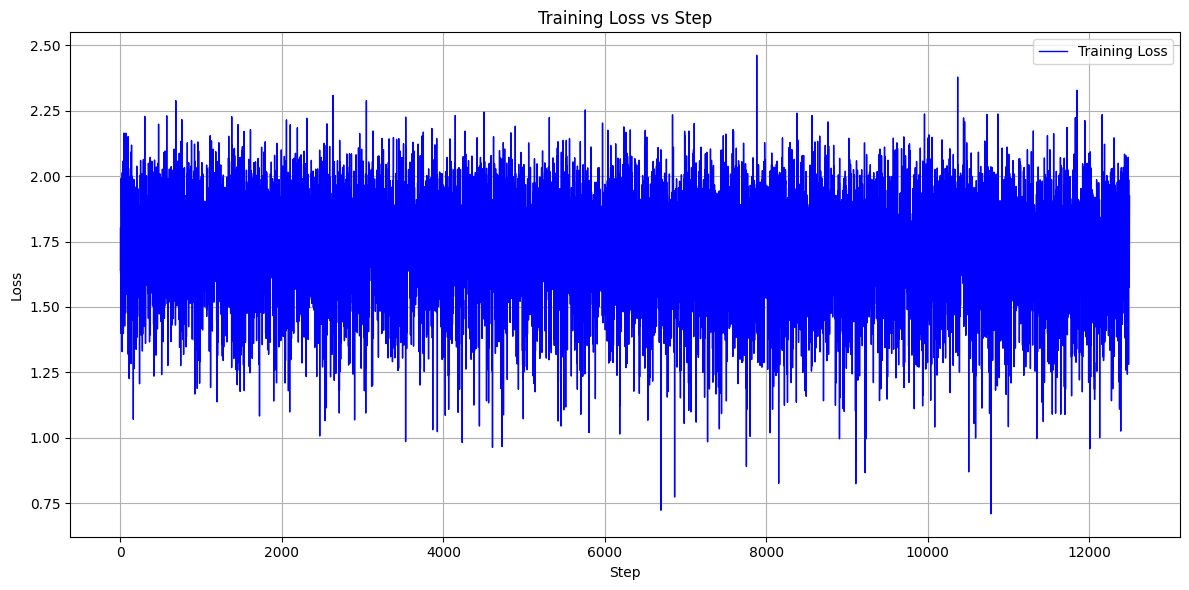

In [50]:
plot_training_loss(training_Loss)

In [ ]:
# @title Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory / max_memory * 100, 3)
lora_percentage = round(used_memory_for_lora / max_memory * 100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(
    f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training."
)
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

<a name="Inference"></a>
### Inference
Let's run the model! You can change the instruction and input - leave the output blank!



In [ ]:
FastLanguageModel.for_inference(model) # Enable native 2x faster inference
inputs = tokenizer(
[
    alpaca_prompt.format(
        "As a store assistant, explain what this product is based on the title.", # instruction
        "The Very Bad Bunny (Beginner Series)", # input
        "", # output - leave this blank for generation!
    )
], return_tensors = "pt").to("cuda")

outputs = model.generate(**inputs, max_new_tokens = 64, use_cache = True)
tokenizer.batch_decode(outputs)

["<|begin_of_text|>Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.\n\n### Instruction:\nAs a store assistant, explain what this product is based on the title.\n\n### Input:\nThe Very Bad Bunny (Beginner Series)\n\n### Response:\nGr 1-3–The bunny in these two stories is not a very nice character. He is a bully and a thief. In the first book, he takes away a girl's ball, but it turns out that he is afraid of it. In the second book, he takes a boy's kite and flies"]

In [ ]:
FastLanguageModel.for_inference(model) # Enable native 2x faster inference
inputs = tokenizer(
[
    alpaca_prompt.format(
        "As a store assistant, explain what this book is based on the title.", # instruction
        "Paris on the Eve 1900-1914", # input
        "", # output - leave this blank for generation!
    )
], return_tensors = "pt").to("cuda")


outputs = model.generate(
    **inputs,
    max_new_tokens=128,
    temperature=0.7,
    top_p=0.9,       # nucleus sampling
    top_k=50,        # top-k sampling
    do_sample=True,  # ativa amostragem (necessário para usar temperatura/top_k/top_p)
    use_cache=True
)
tokenizer.batch_decode(outputs)

["<|begin_of_text|>Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.\n\n### Instruction:\nAs a store assistant, explain what this book is based on the title.\n\n### Input:\nParis on the Eve 1900-1914\n\n### Response:\nThe Paris of the early 20th century was the most vibrant and exciting city in the world, and it is the author's aim in this volume to present a detailed picture of that world, its people, its ideas and its history. The author, who is a professor at New York University, has written a fascinating and well-documented study. He is a talented and entertaining writer, and his book is an enjoyable read. Highly recommended for public and academic libraries.- Lawrence Maxted, Oxfordshire County Lib., EnglandCopyright 1991 Reed Business Information, Inc.<|end_of_text|>"]

In [ ]:
FastLanguageModel.for_inference(model) # Enable native 2x faster inference
inputs = tokenizer(
[
    alpaca_prompt.format(
        "As a store assistant, explain what this product is based on the title.", # instruction
        "Girls Ballet Tutu Neon Pink.", # input
        "", # output - leave this blank for generation!
    )
], return_tensors = "pt").to("cuda")

outputs = model.generate(
    **inputs,
    max_new_tokens=512,
    temperature=0.1,
    top_p=0.9,       # nucleus sampling
    top_k=50,        # top-k sampling
    do_sample=True,  # ativa amostragem (necessário para usar temperatura/top_k/top_p)
    use_cache=True
)
tokenizer.batch_decode(outputs)

['<|begin_of_text|>Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.\n\n### Instruction:\nAs a store assistant, explain what this product is based on the title.\n\n### Input:\nGirls Ballet Tutu Neon Pink.\n\n### Response:\nThis is a tutu that is made of a soft, stretchy material. It is a one piece tutu that is made of a soft, stretchy material. It is a one piece tutu that is made of a soft, stretchy material. It is a one piece tutu that is made of a soft, stretchy material. It is a one piece tutu that is made of a soft, stretchy material. It is a one piece tutu that is made of a soft, stretchy material. It is a one piece tutu that is made of a soft, stretchy material. It is a one piece tutu that is made of a soft, stretchy material. It is a one piece tutu that is made of a soft, stretchy material. It is a one piece tutu that is made of a soft, stretchy material. It is a one piece

 You can also use a `TextStreamer` for continuous inference - so you can see the generation token by token, instead of waiting the whole time!

In [ ]:
FastLanguageModel.for_inference(model) # Enable native 2x faster inference
inputs = tokenizer(
[
    alpaca_prompt.format(
        "As a store assistant, explain what this product is based on the title.", # instruction
        "Paris on the Eve 1900-1914", # input
        "", # output - leave this blank for generation!
    )
], return_tensors = "pt").to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 512)

<|begin_of_text|>Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
As a store assistant, explain what this product is based on the title.

### Input:
Paris on the Eve 1900-1914

### Response:
Text: English (translation)Original Language: French<|end_of_text|>


In [ ]:
FastLanguageModel.for_inference(model) # Enable native 2x faster inference
inputs = tokenizer(
[
    alpaca_prompt.format(
        "As a store assistant, explain what this product is based on the title.", # instruction
        "Girls Ballet Tutu Neon Pink.", # input
        "", # output - leave this blank for generation!
    )
], return_tensors = "pt").to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128)

<|begin_of_text|>Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
As a store assistant, explain what this product is based on the title.

### Input:
Tell me about the Girls Ballet Tutu Neon Pink.

### Response:
Tutu's are a must have for any little girl's wardrobe. This bright pink tutu is a great addition to any ballet costume.<|end_of_text|>


<a name="Save"></a>
### Saving, loading finetuned models
To save the final model as LoRA adapters, either use Huggingface's `push_to_hub` for an online save or `save_pretrained` for a local save.

**[NOTE]** This ONLY saves the LoRA adapters, and not the full model. To save to 16bit or GGUF, scroll down!

In [ ]:
model.save_pretrained(f"{DATA_DIR}/lora_model_alpaca")  # Local saving
tokenizer.save_pretrained(f"{DATA_DIR}/lora_model_alpaca")  # Local saving

('/content/drive/MyDrive/FIAP/tcFase3Grupo9/lora_model_alpaca/tokenizer_config.json',
 '/content/drive/MyDrive/FIAP/tcFase3Grupo9/lora_model_alpaca/special_tokens_map.json',
 '/content/drive/MyDrive/FIAP/tcFase3Grupo9/lora_model_alpaca/tokenizer.json')

Now if you want to load the LoRA adapters we just saved for inference, set `False` to `True`:

In [41]:
if False:
    from unsloth import FastLanguageModel
    model, tokenizer = FastLanguageModel.from_pretrained(
        model_name = f"{DATA_DIR}/lora_model_alpaca", # YOUR MODEL YOU USED FOR TRAINING
        max_seq_length = max_seq_length,
        dtype = dtype,
        load_in_4bit = load_in_4bit,
    )
    FastLanguageModel.for_inference(model) # Enable native 2x faster inference

# alpaca_prompt = You MUST copy from above!

inputs = tokenizer(
[
    alpaca_prompt.format(
        "What is a famous tall tower in Paris?", # instruction
        "", # input
        "", # output - leave this blank for generation!
    )
], return_tensors = "pt").to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128)

<|begin_of_text|>Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
What is a famous tall tower in Paris?

### Input:


### Response:
The Eiffel Tower is a large, wrought-iron tower located on the Champ de Mars in Paris, France. The tower was constructed between 1887 and 1889 as the centerpiece of the 1889 World's Fair. It has since become one of the most recognizable structures in the world, and is the most visited paid monument in the world.<|end_of_text|>


You can also use Hugging Face's `AutoModelForPeftCausalLM`. Only use this if you do not have `unsloth` installed. It can be hopelessly slow, since `4bit` model downloading is not supported, and Unsloth's **inference is 2x faster**.

In [43]:
if False:
    # I highly do NOT suggest - use Unsloth if possible
    from peft import AutoPeftModelForCausalLM
    from transformers import AutoTokenizer
    model = AutoPeftModelForCausalLM.from_pretrained(
        f"{DATA_DIR}/lora_model_alpaca", # YOUR MODEL YOU USED FOR TRAINING
        load_in_4bit = load_in_4bit,
    )
    tokenizer = AutoTokenizer.from_pretrained(f"{DATA_DIR}/lora_model_alpaca")